**Auteur :** Paul Erian

**Date :** 08/08/2021

# Préparation de la BDD

**Bibliothèques et Téléchargements**

In [1]:
# Import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Telechargement Fashion MNIST
train, test = tf.keras.datasets.fashion_mnist.load_data()

**Récupération des données**

In [3]:
# Nom des classes
dict_labels = { 0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}

In [4]:
train_imgs   = train[0]
train_labels = train[1]
N_training = train_imgs.shape[0]
print(f"Nb données entrainement + validation : {N_training}.")

Nb données entrainement + validation : 60000.


In [5]:
# Organisation de la BDD
x_train   = train_imgs[10000:]
y_train = train_labels[10000:]
x_val = train_imgs[:10000]
y_val = train_labels[:10000]
x_test    = test[0]
y_test  = test[1]

In [6]:
# Affichage de la taille
N_train = x_train.shape[0]
N_val = x_val.shape[0]
N_test  = x_test.shape[0]
print(f"Nb données entrainement : {N_train}.")
print(f"Nb données validation   : {N_val}.")
print(f"Nb données test         : {N_test}.")

Nb données entrainement : 50000.
Nb données validation   : 10000.
Nb données test         : 10000.


In [7]:
# Conversion
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.uint8)

x_val = x_val.astype(np.float32)
y_val = y_val.astype(np.uint8)

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.uint8)

**Visualisation des données**

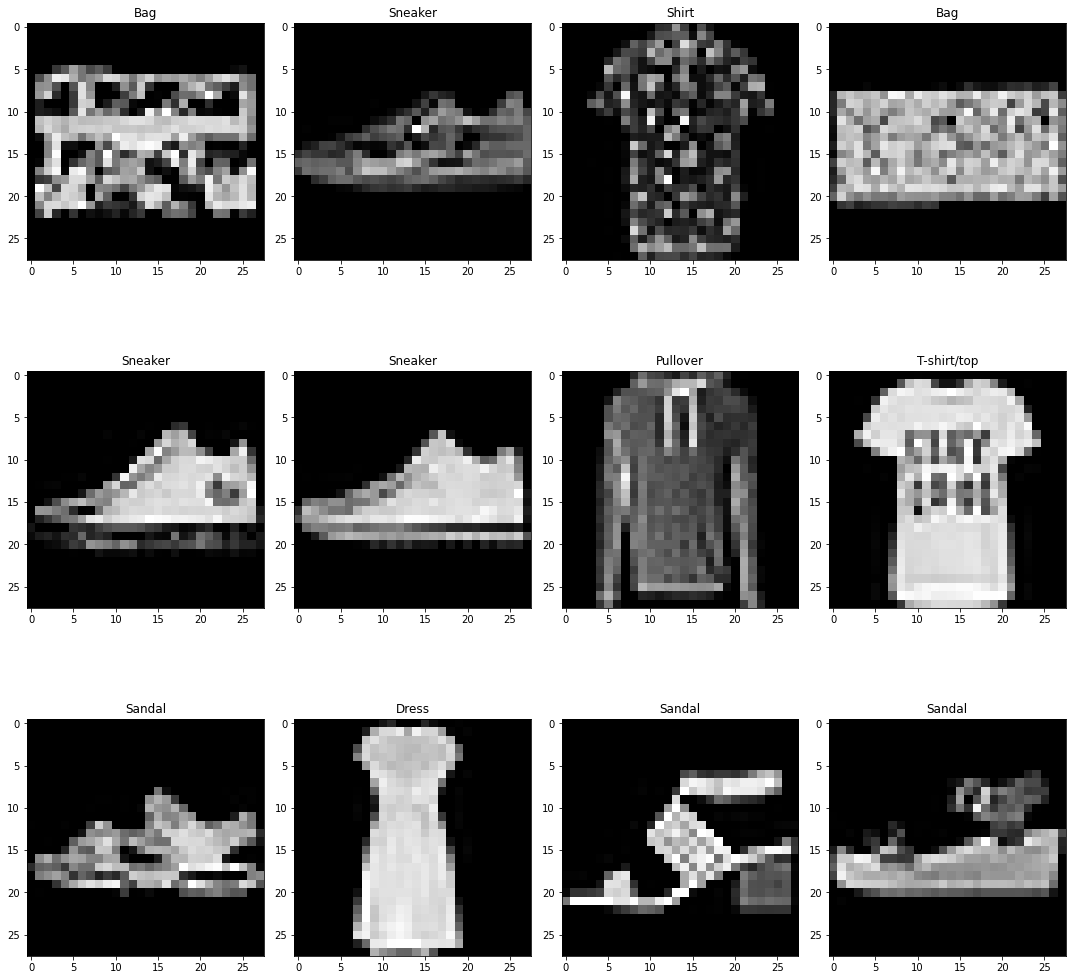

In [8]:
# Visualisation
fig = plt.figure(figsize=(15,15))
for k in range(12):
  # chargement
  img = x_train[k,:,:]
  label_num = y_train[k]
  # affichage
  plt.subplot(3,4,k+1)
  plt.imshow(img,cmap='gray')
  plt.title(dict_labels[label_num])

fig.tight_layout()
plt.show()


**Création d'une BDD Tensorflow**

In [9]:
def one_hot_encoding(img, label):
  out = tf.one_hot(label,10,dtype=tf.uint8)
  return(img, out)

def add_channel(img, label):
  out = tf.expand_dims(img, axis=2)
  return(out, label)

def augment(img, label):
  out = tf.image.random_flip_left_right(img)
  return(out, label)


def normalise(img, label):
  mean = tf.reduce_mean(img)
  std = tf.math.reduce_std(img)
  out = (img - mean)/std
  return(out, label)


In [10]:
BATCH_SIZE = 32
def prepare_ds(x,y):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = (ds
    .map(one_hot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
    .map(add_channel, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .map(normalise, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
  )
  return ds

In [11]:
train_ds = prepare_ds(x_train, y_train)
val_ds = prepare_ds(x_val, y_val)
print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.uint8)>
<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.uint8)>


**Construction du modèle**

In [12]:
# C32 -> ReLu -> Batchnorm -> Maxpool
# C64 -> ReLu -> Batchnorm -> Maxpool
# FC512 -> ReLu
# FC10 -> Softmax
def Model():
  inputs = tf.keras.Input(shape=(28, 28, 1), name='input_image')

  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="SAME", activation="relu")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='SAME')(x)

  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="SAME", activation="relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='SAME')(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate= 0.5)(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [13]:
model = Model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0     

# Entraînement



**Paramètres d'entrainement**

In [14]:
epochs = 30
learning_rate = 1e-3
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [15]:
print(f"Nb epoch                : {epochs}")
print(f"Nb données entrainement : {N_train}")
print(f"Taille d'un lot         : {BATCH_SIZE}")
print(f"Nb étape par epoch      : { int(np.ceil(N_train/BATCH_SIZE)) }")
print(f"Fonctions de cout       : {loss.name}")
print(f"Optimisation            : Adam")
print(f"Learning rate           : {learning_rate}")

Nb epoch                : 30
Nb données entrainement : 50000
Taille d'un lot         : 32
Nb étape par epoch      : 1563
Fonctions de cout       : categorical_crossentropy
Optimisation            : Adam
Learning rate           : 0.001


**Métriques utilisées**

In [16]:
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

**Listes contenant les valeurs des métriques/ loss**

In [17]:
# pour 1 epoch
train_loss_list =[]
val_loss_list = []
# pour l'ensemble des epochs
train_loss_per_epoch = []
train_acc_per_epoch = []
val_loss_per_epoch = []
val_acc_per_epoch = []


**Test GPU**

In [18]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Création d'un repertoire de sauvegarde**

In [19]:
# creation d'un repertoire saved_model
!mkdir -p saved_model

**Entraînement**

In [20]:
train_from_scratch = True #@param {type:"boolean"}

if train_from_scratch:
  out_text = "entrainement à partir de 0"
  model = Model()
else:
  out_text = "entrainement à partir du dernier checkpoint"
  model = tf.keras.models.load_model('saved_model/my_model')

print(out_text)

entrainement à partir de 0


In [21]:
for epoch in range(epochs):
  ## ENTRAINEMENT
  for step, (x_train_batch, y_train_batch) in enumerate(train_ds):
    # calcul de la loss
    with tf.GradientTape() as tape:
      logits = model(x_train_batch, training=True)
      loss_value = loss(y_train_batch, logits)
    # calcul du gradient
    grads = tape.gradient(loss_value, model.trainable_weights)
    # mise à jour des poids du réseau
    opt.apply_gradients(zip(grads, model.trainable_weights))
    # MAJ metrique
    train_loss_list.append(loss_value)
    train_acc_metric.update_state(y_train_batch, logits)

    # Affichage
    if step % 500 == 0:
      print("step : %d, loss : %.4f"% (step, float(loss_value)))
  
  ## VALIDATION
  for x_val_batch, y_val_batch in val_ds:
    val_logits = model(x_val_batch, training=False)
    val_loss_value = loss(y_val_batch, val_logits)
    # MAJ metrics
    val_loss_list.append(val_loss_value)
    val_acc_metric.update_state(y_val_batch, val_logits)

  ## CALCUL METRIQUE
  train_loss = np.sum(train_loss_list)/len(train_loss_list)
  train_acc = train_acc_metric.result()
  val_loss = np.sum(val_loss_list)/len(val_loss_list)
  val_acc = val_acc_metric.result()

  ## SAVE MODEL
  if (epoch ==0 or (smaller_val_loss>val_loss)):
    smaller_val_loss = val_loss
    model.save('saved_model/my_model')

  ## AFFICHAGE
  print(f"Epoch {epoch+1}",end=" - ")
  print("Training loss: %.4f" % train_loss, end=" - ")
  print("Training accuracy: %.4f" % (float(train_acc)),end=" - ")
  print("Validation loss: %.4f" % val_loss, end=" - ")
  print("Validation accuracy: %.4f" % (float(val_acc)))

  ## SAUVEGARDE + RESET
  train_loss_per_epoch.append(train_loss)
  train_acc_per_epoch.append(train_acc)
  val_loss_per_epoch.append(val_loss)
  val_acc_per_epoch.append(val_acc)
  # reset metriques
  train_loss_list = []
  val_loss_list = []
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()


step : 0, loss : 4.8789
step : 500, loss : 0.4559
step : 1000, loss : 1.1883
step : 1500, loss : 0.6699
INFO:tensorflow:Assets written to: saved_model/my_model/assets
Epoch 1 - Training loss: 0.5409 - Training accuracy: 0.8186 - Validation loss: 0.3095 - Validation accuracy: 0.8878
step : 0, loss : 0.2113
step : 500, loss : 0.3563
step : 1000, loss : 0.7040
step : 1500, loss : 0.4196
INFO:tensorflow:Assets written to: saved_model/my_model/assets
Epoch 2 - Training loss: 0.3649 - Training accuracy: 0.8697 - Validation loss: 0.2835 - Validation accuracy: 0.8958
step : 0, loss : 0.1791
step : 500, loss : 0.1677
step : 1000, loss : 0.6265
step : 1500, loss : 0.6129
INFO:tensorflow:Assets written to: saved_model/my_model/assets
Epoch 3 - Training loss: 0.3191 - Training accuracy: 0.8856 - Validation loss: 0.2659 - Validation accuracy: 0.9027
step : 0, loss : 0.1889
step : 500, loss : 0.2424
step : 1000, loss : 1.0278
step : 1500, loss : 0.2880
INFO:tensorflow:Assets written to: saved_model/

**Résultats d'entrainement**

Text(0.5, 1.0, 'traning and validation accuracy')

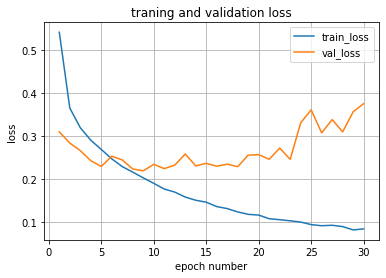

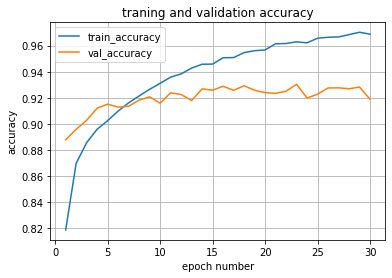

In [22]:
x = [(i+1) for i in range(epochs)]

plt.figure()
plt.plot(x,train_loss_per_epoch)
plt.plot(x,val_loss_per_epoch)
plt.xlabel("epoch number")
plt.ylabel("loss")
plt.legend(("train_loss","val_loss"))
plt.grid()
plt.title("traning and validation loss")

plt.figure()
plt.plot(x,train_acc_per_epoch)
plt.plot(x,val_acc_per_epoch)
plt.xlabel("epoch number")
plt.ylabel("accuracy")
plt.legend(("train_accuracy","val_accuracy"))
plt.grid()
plt.title("traning and validation accuracy")

#Inférence

In [23]:
model = tf.keras.models.load_model('saved_model/my_model')

In [24]:
def make_prediction(model, img):
  img = np.expand_dims(img,axis=2)
  img = np.expand_dims(img,axis=0)
  vec_pred = model.predict(img)
  return vec_pred

def onehot2lab(vec):
  idx = np.argmax(vec)
  return dict_labels[idx]

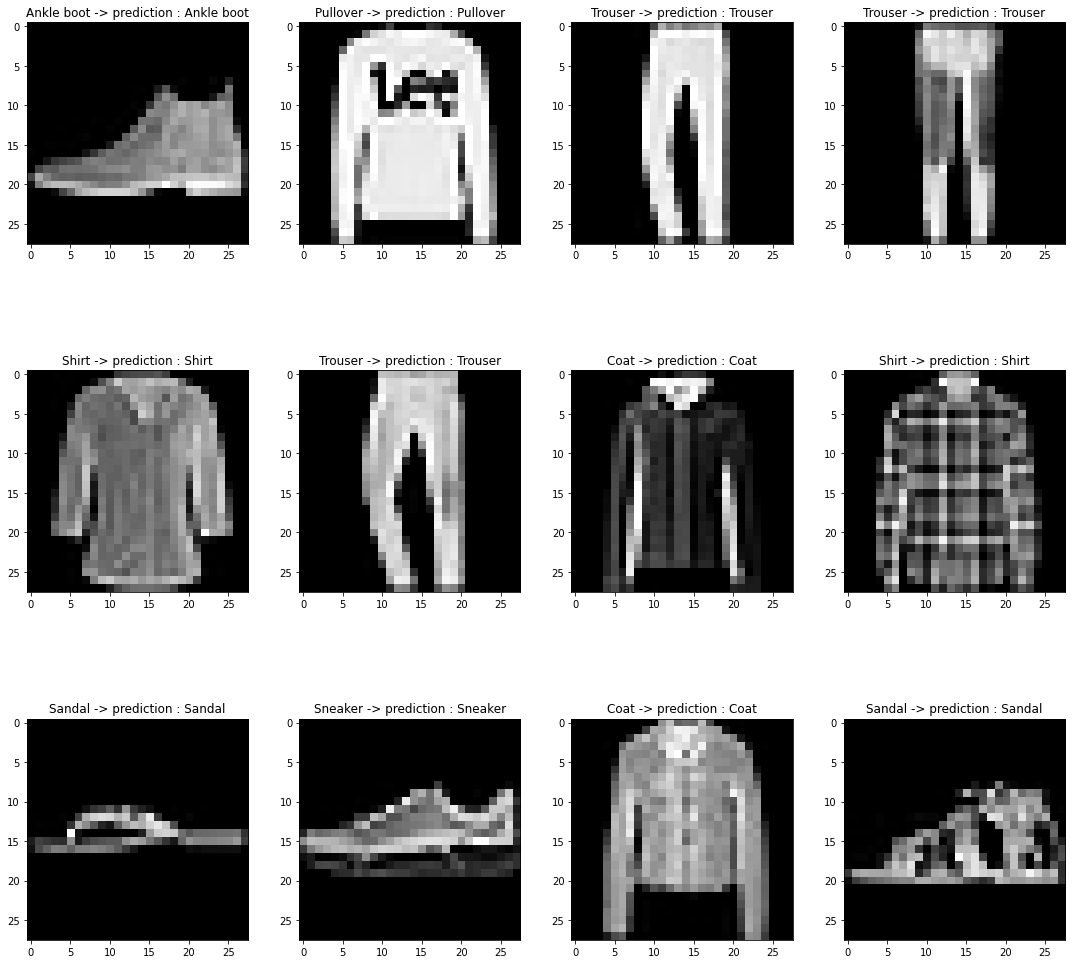

In [25]:
# Visualisation
fig = plt.figure(figsize=(15,15))
for k in range(12):
  # chargement
  img = x_test[k,:,:]
  label_num = y_test[k]
  # normalisation
  img, label_num = normalise(img,label_num)
  # prediction
  vec_label = make_prediction(model,img)
  pred_label = onehot2lab(vec_label)
  # affichage
  plt.subplot(3,4,k+1)
  plt.imshow(img,cmap='gray')
  plt.title(f"{dict_labels[label_num]} -> prediction : {pred_label}")

fig.tight_layout()
plt.show()

# Testing

**Métriques**

In [26]:
test_acc_metric = tf.keras.metrics.CategoricalAccuracy()
test_pres_metric = tf.keras.metrics.Precision()

**Test**

In [27]:
gt_list = []
pred_list = []
for k,(img, label_num) in enumerate(zip(x_test, y_test)):
  img, label_num = normalise(img,label_num)
  img, vec_label = one_hot_encoding(img, label_num)
  # chargement
  pred_vec = make_prediction(model,img)[0]
  # ajout aux listes de gt/prediction
  gt_list.append(label_num)
  pred_list.append(np.argmax(pred_vec))
  # calcul metriques
  test_acc_metric.update_state(vec_label,pred_vec)
  test_pres_metric.update_state(vec_label,pred_vec)
  if (k%500 == 0):
    print(f"{k}/{N_test}")

0/10000
500/10000
1000/10000
1500/10000
2000/10000
2500/10000
3000/10000
3500/10000
4000/10000
4500/10000
5000/10000
5500/10000
6000/10000
6500/10000
7000/10000
7500/10000
8000/10000
8500/10000
9000/10000
9500/10000


**Accuracy et Precision**

In [28]:
print(f"Accuracy : {test_acc_metric.result().numpy()}")
print(f"Precision : {test_pres_metric.result().numpy()}")

Accuracy : 0.9154000282287598
Precision : 0.9281179308891296


In [30]:
conf_mat = tf.math.confusion_matrix(gt_list, pred_list)
print("Matrice de confusion : ")
print(conf_mat.numpy())
print(dict_labels)

Matrice de confusion : 
[[902   0   7  24   6   3  53   0   5   0]
 [  1 977   1  17   0   0   3   0   1   0]
 [ 19   1 843   7  84   0  46   0   0   0]
 [ 16   0   5 930  32   0  17   0   0   0]
 [  1   0  27  28 903   0  40   0   1   0]
 [  0   0   0   0   0 979   0  12   0   9]
 [130   0  47  32  83   0 698   0  10   0]
 [  0   0   0   0   0   6   0 966   0  28]
 [  2   0   0   2   1   1   1   2 988   3]
 [  0   0   0   0   0   5   1  26   0 968]]
{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
